In [1]:
#!pip install xgboost

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, 
                             ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay)

## Знакомство с данными и их предобработка

In [3]:
# Чтение csv файла и формирование датафрейма.
path = os.path.join(os.getcwd(), 'train_7.csv')
data = pd.read_csv(path, sep=',')
data

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,715630983,31,F,0,Graduate,Single,Less than $40K,Blue,21,4,...,3,4598.0,0,4598.0,0.439,6317,77,0.833,0.000,Attrited Customer
1,713643858,53,F,1,College,Married,$40K - $60K,Blue,43,4,...,2,1525.0,1411,114.0,0.660,1911,47,0.958,0.925,Existing Customer
2,708334158,46,F,3,Graduate,Divorced,Less than $40K,Blue,34,4,...,4,9863.0,686,9177.0,0.581,3068,58,0.933,0.070,Existing Customer
3,711033408,50,F,2,High School,Married,Less than $40K,Blue,36,5,...,2,9355.0,1626,7729.0,0.701,1230,28,0.867,0.174,Existing Customer
4,711368283,39,M,2,Unknown,Married,$80K - $120K,Blue,27,3,...,2,34516.0,1629,32887.0,1.078,3448,53,1.038,0.047,Existing Customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7590,772596783,31,M,1,Graduate,Unknown,Less than $40K,Gold,21,3,...,2,15261.0,1109,14152.0,0.655,15442,125,0.761,0.073,Existing Customer
7591,820330008,46,M,5,High School,Married,$120K +,Blue,42,1,...,3,32926.0,1540,31386.0,0.862,8231,98,0.556,0.047,Existing Customer
7592,720614658,40,M,2,High School,Divorced,$60K - $80K,Blue,25,6,...,2,2978.0,0,2978.0,0.490,3879,95,0.583,0.000,Existing Customer
7593,709759908,46,M,2,Graduate,Married,$60K - $80K,Blue,36,4,...,2,1939.0,685,1254.0,0.421,4327,84,0.680,0.353,Existing Customer


In [4]:
# Информация о наименовании колонок, типах данных, используемой памяти, кол-ве строк и колонок, кол-во непустых 
# значений в колонке.
data.info()
# 21 колонка, 7595 строк. 6 типов object, 15 типов numeric переменных. Пустых значений нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7595 entries, 0 to 7594
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 7595 non-null   int64  
 1   Customer_Age              7595 non-null   int64  
 2   Gender                    7595 non-null   object 
 3   Dependent_count           7595 non-null   int64  
 4   Education_Level           7595 non-null   object 
 5   Marital_Status            7595 non-null   object 
 6   Income_Category           7595 non-null   object 
 7   Card_Category             7595 non-null   object 
 8   Months_on_book            7595 non-null   int64  
 9   Total_Relationship_Count  7595 non-null   int64  
 10  Months_Inactive_12_mon    7595 non-null   int64  
 11  Contacts_Count_12_mon     7595 non-null   int64  
 12  Credit_Limit              7595 non-null   float64
 13  Total_Revolving_Bal       7595 non-null   int64  
 14  Avg_Open

Existing Customer    6375
Attrited Customer    1220
Name: Attrition_Flag, dtype: int64


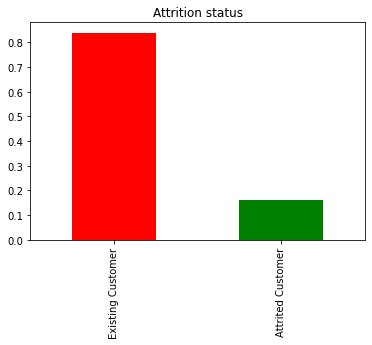

In [5]:
# Колонка Attrition_Flag. Aктивность клиента - если учетная запись закрыта, то Attrited Customer, иначе Existing Customer - 
# target column
# Количество и доля имеющих и не имеющих учетные записи.
print(data['Attrition_Flag'].value_counts())
data['Attrition_Flag'].value_counts(True).plot(kind='bar', title='Attrition status', color = ['r', 'g'])
plt.show()
# Присутствует явный дисбаланс классов (имеющих учетную запись больше, чем не имеющих). 

In [6]:
# Доля имеющих и не имеющих учетные записи.
data['Attrition_Flag'].value_counts(True)

Existing Customer    0.839368
Attrited Customer    0.160632
Name: Attrition_Flag, dtype: float64

In [7]:
# Чтение csv файла и формирование датафрейма теста.
path = os.path.join(os.getcwd(), 'validation_7.csv')
test = pd.read_csv(path, sep=',')
test

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,719682183,53,F,2,Unknown,Single,$40K - $60K,Blue,43,3,4,4,6188.0,2517,3671.0,0.713,1997,43,1.048,0.407
1,711341433,34,F,2,Graduate,Single,Unknown,Blue,24,6,3,3,3095.0,2010,1085.0,0.668,3901,77,0.711,0.649
2,716154258,48,M,4,Doctorate,Unknown,$60K - $80K,Silver,38,3,2,2,32658.0,1482,31176.0,0.941,2023,37,0.542,0.045
3,779749908,48,M,4,College,Married,$60K - $80K,Gold,33,2,2,3,34516.0,2061,32455.0,0.722,1350,32,0.455,0.060
4,710854008,48,M,3,Unknown,Unknown,$40K - $60K,Blue,37,3,2,4,6541.0,1119,5422.0,0.496,3902,63,0.432,0.171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,710268858,33,F,4,Graduate,Single,Less than $40K,Blue,22,5,1,2,2001.0,1217,784.0,0.775,3162,99,0.707,0.608
2528,714130233,39,M,2,Unknown,Married,$60K - $80K,Blue,19,3,3,2,3047.0,2150,897.0,0.882,1602,37,1.312,0.706
2529,708823908,41,M,3,Graduate,Single,$60K - $80K,Blue,28,4,1,3,16443.0,1363,15080.0,0.688,4252,64,0.684,0.083
2530,771045708,41,F,5,Graduate,Married,Less than $40K,Blue,28,2,3,3,1504.0,970,534.0,0.864,2801,51,1.217,0.645


In [8]:
# Информация о наименовании колонок, типах данных, используемой памяти, кол-ве строк и колонок, кол-во непустых 
# значений в колонке.
test.info()
# 20 колонок, 2532 строк. 5 типов object, 15 типов numeric переменных. Пустых значений нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2532 entries, 0 to 2531
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 2532 non-null   int64  
 1   Customer_Age              2532 non-null   int64  
 2   Gender                    2532 non-null   object 
 3   Dependent_count           2532 non-null   int64  
 4   Education_Level           2532 non-null   object 
 5   Marital_Status            2532 non-null   object 
 6   Income_Category           2532 non-null   object 
 7   Card_Category             2532 non-null   object 
 8   Months_on_book            2532 non-null   int64  
 9   Total_Relationship_Count  2532 non-null   int64  
 10  Months_Inactive_12_mon    2532 non-null   int64  
 11  Contacts_Count_12_mon     2532 non-null   int64  
 12  Credit_Limit              2532 non-null   float64
 13  Total_Revolving_Bal       2532 non-null   int64  
 14  Avg_Open

In [9]:
client_id = test['CLIENTNUM']

In [10]:
# Проверка названий и порядка колонок в обучающей и тестовой выборках.
data.drop('Attrition_Flag', axis=1).columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [11]:
# Объединение обучающей и тестовой выборки без таргета.
data_test = pd.concat([data.drop('Attrition_Flag', axis=1), test])
data_test

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,715630983,31,F,0,Graduate,Single,Less than $40K,Blue,21,4,2,3,4598.0,0,4598.0,0.439,6317,77,0.833,0.000
1,713643858,53,F,1,College,Married,$40K - $60K,Blue,43,4,4,2,1525.0,1411,114.0,0.660,1911,47,0.958,0.925
2,708334158,46,F,3,Graduate,Divorced,Less than $40K,Blue,34,4,2,4,9863.0,686,9177.0,0.581,3068,58,0.933,0.070
3,711033408,50,F,2,High School,Married,Less than $40K,Blue,36,5,1,2,9355.0,1626,7729.0,0.701,1230,28,0.867,0.174
4,711368283,39,M,2,Unknown,Married,$80K - $120K,Blue,27,3,3,2,34516.0,1629,32887.0,1.078,3448,53,1.038,0.047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,710268858,33,F,4,Graduate,Single,Less than $40K,Blue,22,5,1,2,2001.0,1217,784.0,0.775,3162,99,0.707,0.608
2528,714130233,39,M,2,Unknown,Married,$60K - $80K,Blue,19,3,3,2,3047.0,2150,897.0,0.882,1602,37,1.312,0.706
2529,708823908,41,M,3,Graduate,Single,$60K - $80K,Blue,28,4,1,3,16443.0,1363,15080.0,0.688,4252,64,0.684,0.083
2530,771045708,41,F,5,Graduate,Married,Less than $40K,Blue,28,2,3,3,1504.0,970,534.0,0.864,2801,51,1.217,0.645


In [12]:
# Проверка пропущенных значений. Пропущенных значений в колонках нет.
print(data_test.isnull().sum().sum())
data_test.isna().sum().sum()

0


0

In [13]:
# Номер клиента. Уникальный идентификатор клиента, которому принадлежит счет (unique ID)
print(data_test['CLIENTNUM'].nunique())

10127


In [14]:
# Проверка дублирующих строк. Дублирующих строк нет.
data_test.drop('CLIENTNUM', axis=1).duplicated().sum()

0

In [15]:
# Описательная статистика для числовых колонок.
data_test.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [16]:
# Описательная статистика для колонок object.
data_test.describe(exclude=['float64', 'int64'])

,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,10127,10127,10127
unique,2,7,4,6,4
top,F,Graduate,Married,Less than $40K,Blue
freq,5358,3128,4687,3561,9436


In [17]:
# Уникальные значения для всех колонок датасета
for col in data_test.columns:
    print(data_test[col].value_counts())
    print('*'*30)

717091533    1
720145683    1
813153108    1
720697908    1
714802458    1
            ..
737962608    1
814989933    1
720599658    1
787849833    1
721462458    1
Name: CLIENTNUM, Length: 10127, dtype: int64
******************************
44    500
49    495
46    490
45    486
47    479
43    473
48    472
50    452
42    426
51    398
53    387
41    379
52    376
40    361
39    333
54    307
38    303
55    279
56    262
37    260
57    223
36    221
35    184
59    157
58    157
34    146
60    127
33    127
32    106
65    101
61     93
62     93
31     91
26     78
30     70
63     65
29     56
64     43
27     32
28     29
67      4
66      2
68      2
73      1
70      1
Name: Customer_Age, dtype: int64
******************************
F    5358
M    4769
Name: Gender, dtype: int64
******************************
3    2732
2    2655
1    1838
4    1574
0     904
5     424
Name: Dependent_count, dtype: int64
******************************
Graduate         3128
High School      2

In [18]:
# Разделим клиентов на 5 категорий по возрасту.
data_test['Age_bin'] = pd.cut(data_test['Customer_Age'], [25, 35, 45, 55, 65, 75])

In [19]:
# Количество клиентов по категориям возрастов.
data_test['Age_bin'].value_counts()

(45, 55]    4135
(35, 45]    3742
(55, 65]    1321
(25, 35]     919
(65, 75]      10
Name: Age_bin, dtype: int64

In [20]:
# Разделим клиентов на 5 категорий по периоду отношений с банком в мес.
data_test['Month_bin'] = pd.cut(data_test['Months_on_book'], [10, 20, 30, 40, 50, 60])

In [21]:
# Количество клиентов по категориям периодов отношений с банком.
data_test['Month_bin'].value_counts()

(30, 40]    5424
(40, 50]    2065
(20, 30]    1837
(50, 60]     418
(10, 20]     383
Name: Month_bin, dtype: int64

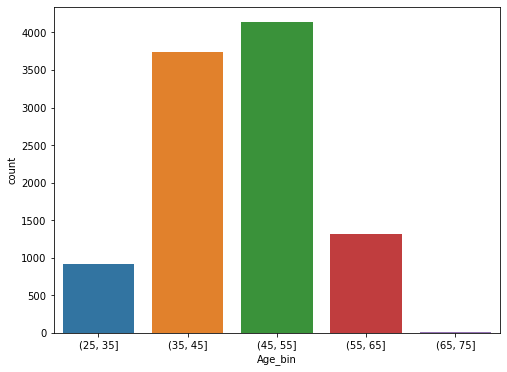

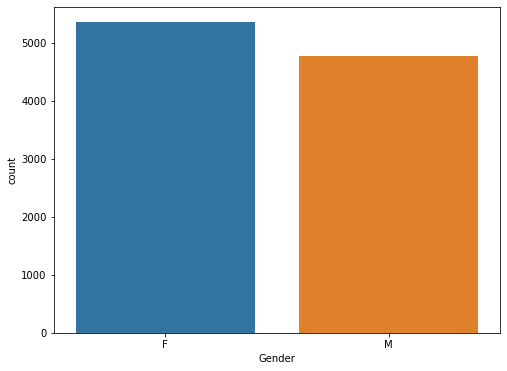

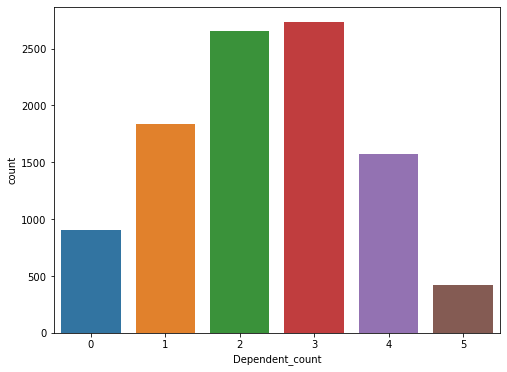

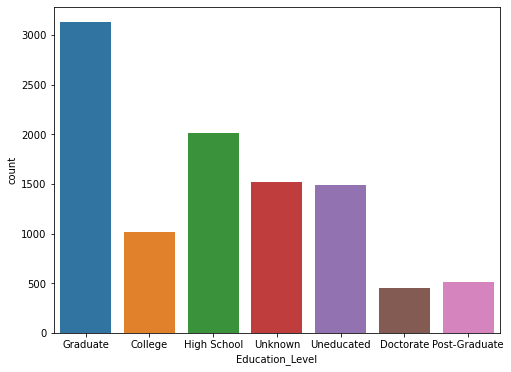

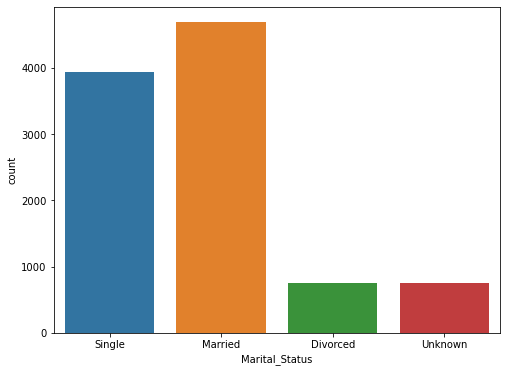

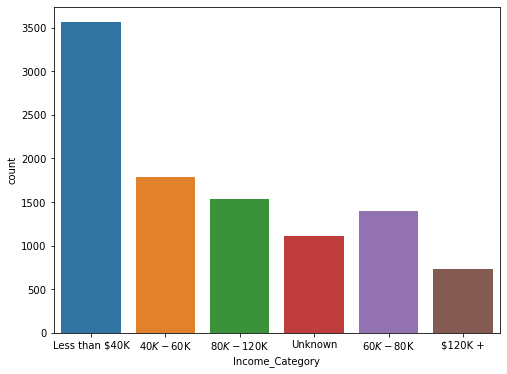

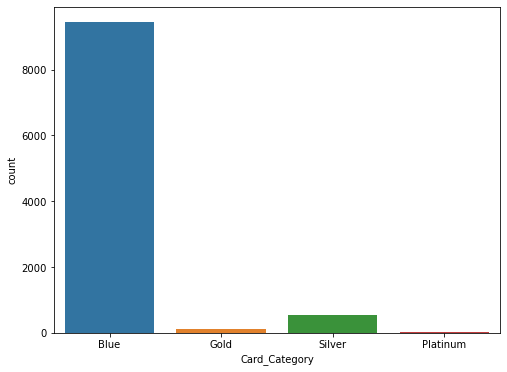

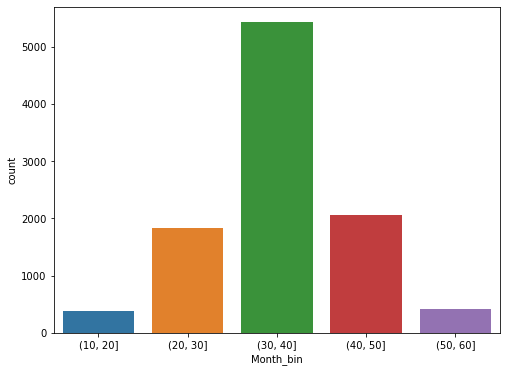

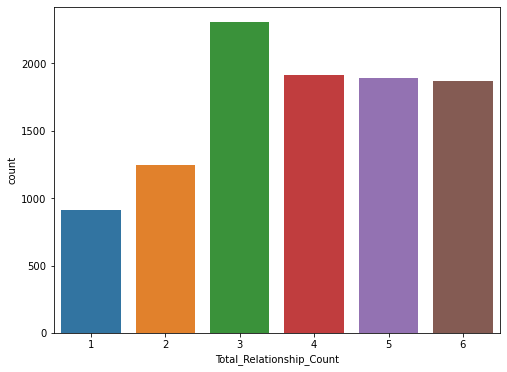

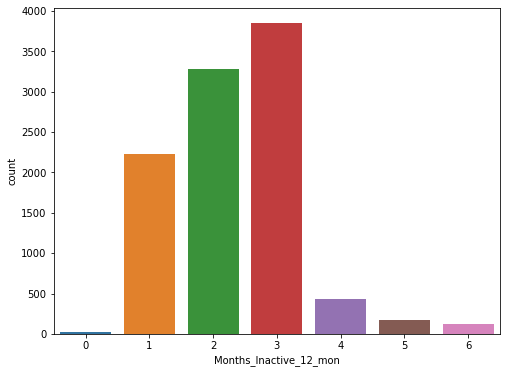

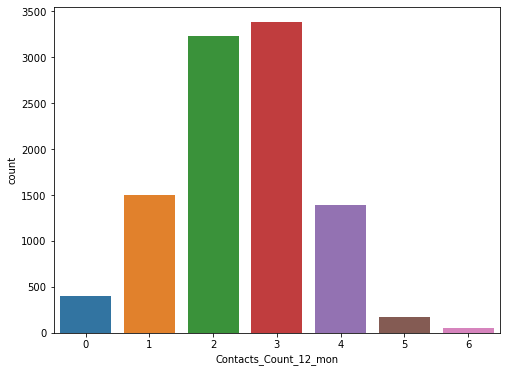

In [22]:
# Отобразим кол-во клиентов по категориям в колонках.
cat_cols = ['Age_bin', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
            'Month_bin', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data_test, x=col)
    plt.show()

In [23]:
# 11 категориальных признаков (из них Dependent_count, Total_Relationship_Count, Months_Inactive_12_mon, Contacts_Count_12_mon
# представлены цифрами), 8 числовых признаков.
cat_cols_cat = ['Age_bin', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Month_bin']
cat_cols_num = ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']
# Преобразование категорий в числовую форму
label_encoder = LabelEncoder()
for col in cat_cols_cat:
    data_test[col] = label_encoder.fit_transform(data_test[col])
    data_test[col] = data_test[col].astype('int8')
for col in cat_cols_num:
    data_test[col] = data_test[col].astype('int8')

In [24]:
# Удаляем колонку с id, не содержит значимой информации. Customer_Age, Months_on_book данные использованы для других столбцов.
data_test.drop(['CLIENTNUM', 'Customer_Age', 'Months_on_book'], axis=1, inplace=True)
data_test

,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Age_bin,Month_bin
0,0,0,2,2,4,0,4,2,3,4598.0,0,4598.0,0.439,6317,77,0.833,0.000,0,1
1,0,1,0,1,1,0,4,4,2,1525.0,1411,114.0,0.660,1911,47,0.958,0.925,2,3
2,0,3,2,0,4,0,4,2,4,9863.0,686,9177.0,0.581,3068,58,0.933,0.070,2,2
3,0,2,3,1,4,0,5,1,2,9355.0,1626,7729.0,0.701,1230,28,0.867,0.174,2,2
4,1,2,6,1,3,0,3,3,2,34516.0,1629,32887.0,1.078,3448,53,1.038,0.047,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,0,4,2,2,4,0,5,1,2,2001.0,1217,784.0,0.775,3162,99,0.707,0.608,0,1
2528,1,2,6,1,2,0,3,3,2,3047.0,2150,897.0,0.882,1602,37,1.312,0.706,1,0
2529,1,3,2,2,2,0,4,1,3,16443.0,1363,15080.0,0.688,4252,64,0.684,0.083,1,1
2530,0,5,2,1,4,0,2,3,3,1504.0,970,534.0,0.864,2801,51,1.217,0.645,1,1


In [25]:
# Общая информация о датасете объединенном.
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 2531
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    10127 non-null  int8   
 1   Dependent_count           10127 non-null  int8   
 2   Education_Level           10127 non-null  int8   
 3   Marital_Status            10127 non-null  int8   
 4   Income_Category           10127 non-null  int8   
 5   Card_Category             10127 non-null  int8   
 6   Total_Relationship_Count  10127 non-null  int8   
 7   Months_Inactive_12_mon    10127 non-null  int8   
 8   Contacts_Count_12_mon     10127 non-null  int8   
 9   Credit_Limit              10127 non-null  float64
 10  Total_Revolving_Bal       10127 non-null  int64  
 11  Avg_Open_To_Buy           10127 non-null  float64
 12  Total_Amt_Chng_Q4_Q1      10127 non-null  float64
 13  Total_Trans_Amt           10127 non-null  int64  
 14  Total_T

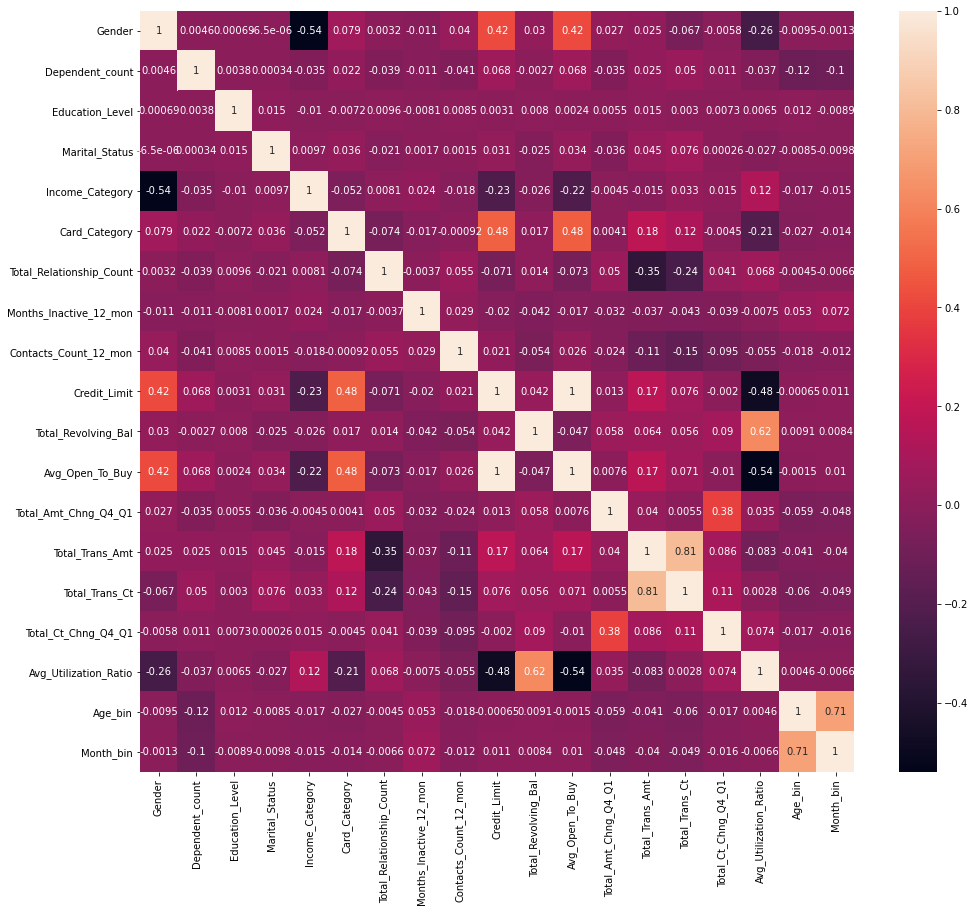

In [26]:
# Корелляция между признаками, есть мультиколлинеарность.
plt.figure(figsize=(16, 14))
sns.heatmap(data_test.corr(), annot=True)
plt.show()

In [27]:
# Корреляция Avg_Open_To_Buy с Credit_Limit = 1, удалим один из столбцов (смотря на корреляцию с таргет, ниже, и попробовав 
# удалить разные столбцы на обучении).
data_test.drop(['Avg_Open_To_Buy'], axis=1, inplace=True)

In [28]:
# Отделяем обучающую и тестовую выборки после обработки колонок.
data_train = data_test.iloc[:7595, :]
test_valid = data_test.iloc[7595:, :]

In [29]:
# Отображаем обучающий датасет
data_train

,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Age_bin,Month_bin
0,0,0,2,2,4,0,4,2,3,4598.0,0,0.439,6317,77,0.833,0.000,0,1
1,0,1,0,1,1,0,4,4,2,1525.0,1411,0.660,1911,47,0.958,0.925,2,3
2,0,3,2,0,4,0,4,2,4,9863.0,686,0.581,3068,58,0.933,0.070,2,2
3,0,2,3,1,4,0,5,1,2,9355.0,1626,0.701,1230,28,0.867,0.174,2,2
4,1,2,6,1,3,0,3,3,2,34516.0,1629,1.078,3448,53,1.038,0.047,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7590,1,1,2,3,4,1,3,2,2,15261.0,1109,0.655,15442,125,0.761,0.073,0,1
7591,1,5,3,1,0,0,1,1,3,32926.0,1540,0.862,8231,98,0.556,0.047,2,3
7592,1,2,3,0,2,0,6,4,2,2978.0,0,0.490,3879,95,0.583,0.000,1,1
7593,1,2,2,1,2,0,4,2,2,1939.0,685,0.421,4327,84,0.680,0.353,2,2


In [30]:
# Отображаем тестовый датасет
test_valid

,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Age_bin,Month_bin
0,0,2,6,2,1,0,3,4,4,6188.0,2517,0.713,1997,43,1.048,0.407,2,3
1,0,2,2,2,5,0,6,3,3,3095.0,2010,0.668,3901,77,0.711,0.649,0,1
2,1,4,1,3,2,3,3,2,2,32658.0,1482,0.941,2023,37,0.542,0.045,2,2
3,1,4,0,1,2,1,2,2,3,34516.0,2061,0.722,1350,32,0.455,0.060,2,2
4,1,3,6,3,1,0,3,2,4,6541.0,1119,0.496,3902,63,0.432,0.171,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,0,4,2,2,4,0,5,1,2,2001.0,1217,0.775,3162,99,0.707,0.608,0,1
2528,1,2,6,1,2,0,3,3,2,3047.0,2150,0.882,1602,37,1.312,0.706,1,0
2529,1,3,2,2,2,0,4,1,3,16443.0,1363,0.688,4252,64,0.684,0.083,1,1
2530,0,5,2,1,4,0,2,3,3,1504.0,970,0.864,2801,51,1.217,0.645,1,1


In [31]:
# Заменяем названия статусов клиентов на 1 или 0.
data['Attrition_Flag'] = data['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
data

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,715630983,31,F,0,Graduate,Single,Less than $40K,Blue,21,4,...,3,4598.0,0,4598.0,0.439,6317,77,0.833,0.000,1
1,713643858,53,F,1,College,Married,$40K - $60K,Blue,43,4,...,2,1525.0,1411,114.0,0.660,1911,47,0.958,0.925,0
2,708334158,46,F,3,Graduate,Divorced,Less than $40K,Blue,34,4,...,4,9863.0,686,9177.0,0.581,3068,58,0.933,0.070,0
3,711033408,50,F,2,High School,Married,Less than $40K,Blue,36,5,...,2,9355.0,1626,7729.0,0.701,1230,28,0.867,0.174,0
4,711368283,39,M,2,Unknown,Married,$80K - $120K,Blue,27,3,...,2,34516.0,1629,32887.0,1.078,3448,53,1.038,0.047,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7590,772596783,31,M,1,Graduate,Unknown,Less than $40K,Gold,21,3,...,2,15261.0,1109,14152.0,0.655,15442,125,0.761,0.073,0
7591,820330008,46,M,5,High School,Married,$120K +,Blue,42,1,...,3,32926.0,1540,31386.0,0.862,8231,98,0.556,0.047,0
7592,720614658,40,M,2,High School,Divorced,$60K - $80K,Blue,25,6,...,2,2978.0,0,2978.0,0.490,3879,95,0.583,0.000,0
7593,709759908,46,M,2,Graduate,Married,$60K - $80K,Blue,36,4,...,2,1939.0,685,1254.0,0.421,4327,84,0.680,0.353,0


In [32]:
# Добавляем колонку со статусом в обучающую выборку.
data_train = pd.concat([data_train, data['Attrition_Flag']], axis=1)
data_train

,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Age_bin,Month_bin,Attrition_Flag
0,0,0,2,2,4,0,4,2,3,4598.0,0,0.439,6317,77,0.833,0.000,0,1,1
1,0,1,0,1,1,0,4,4,2,1525.0,1411,0.660,1911,47,0.958,0.925,2,3,0
2,0,3,2,0,4,0,4,2,4,9863.0,686,0.581,3068,58,0.933,0.070,2,2,0
3,0,2,3,1,4,0,5,1,2,9355.0,1626,0.701,1230,28,0.867,0.174,2,2,0
4,1,2,6,1,3,0,3,3,2,34516.0,1629,1.078,3448,53,1.038,0.047,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7590,1,1,2,3,4,1,3,2,2,15261.0,1109,0.655,15442,125,0.761,0.073,0,1,0
7591,1,5,3,1,0,0,1,1,3,32926.0,1540,0.862,8231,98,0.556,0.047,2,3,0
7592,1,2,3,0,2,0,6,4,2,2978.0,0,0.490,3879,95,0.583,0.000,1,1,0
7593,1,2,2,1,2,0,4,2,2,1939.0,685,0.421,4327,84,0.680,0.353,2,2,0


In [33]:
# Корреляция признаков с таргетом по убыванию.
corr_col = pd.DataFrame([[col, data_train['Attrition_Flag'].corr(data_train[col])] for col in data_train.columns], \
                        columns=['Column', 'Corr_attrition'])
corr_col.sort_values(by='Corr_attrition', ascending=False)

,Column,Corr_attrition
18,Attrition_Flag,1.000000
8,Contacts_Count_12_mon,0.206200
7,Months_Inactive_12_mon,0.153219
1,Dependent_count,0.020994
3,Marital_Status,0.015734
16,Age_bin,0.015608
2,Education_Level,0.013833
17,Month_bin,0.008365
4,Income_Category,0.008362
5,Card_Category,0.001232


In [34]:
# Запишем признаки в переменную X, целевой признак в переменную y.
X = data_train.drop('Attrition_Flag', axis=1)
y = data_train['Attrition_Flag']
# Разделим датафрейм на обучающую и валидационную выборки.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [35]:
# Инициализируем StandardScaler() для стандартизации количественных признаков и применим его на выборки.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[ 1.06233237,  0.49948664, -1.69191301, ..., -0.99414243,
         0.5072558 ,  1.17232406],
       [ 1.06233237,  0.49948664, -1.14980036, ..., -0.48926928,
        -0.70268099, -0.0397939 ],
       [ 1.06233237, -0.27153664,  1.56076286, ..., -0.99414243,
        -0.70268099, -1.25191186],
       ...,
       [-0.94132498,  0.49948664,  1.01865022, ...,  1.09852018,
        -1.91261778, -1.25191186],
       [ 1.06233237,  0.49948664,  1.56076286, ..., -0.72707185,
         0.5072558 ,  1.17232406],
       [-0.94132498, -1.04255992,  1.01865022, ..., -0.99414243,
        -0.70268099, -1.25191186]])

In [36]:
# Смотрим на доли таргета в обучающей выборке.
y_train.value_counts(True)

0    0.839361
1    0.160639
Name: Attrition_Flag, dtype: float64

In [37]:
# Смотрим на размер таргета в обучающей выборке.
y_train.shape

(5696,)

In [38]:
# Смотрим на доли таргета в валидационной выборке.
y_test.value_counts(True)

0    0.839389
1    0.160611
Name: Attrition_Flag, dtype: float64

In [39]:
# Смотрим на размер таргета в валидационной выборке.
y_test.shape

(1899,)

## Обучение модели и оценка качества

In [40]:
# Параметры для XGBClassifier
xgb.XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [41]:
# Параметры для подбора.
param = {
    'max_depth': np.arange(4, 10),
    'learning_rate': [0.1, 0.01],
    'gamma': [0.25, 0.5, 1],
    'scale_pos_weight': [1, 3, 5]
}

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)
Best score: 0.8962898432550406
Params: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 1}


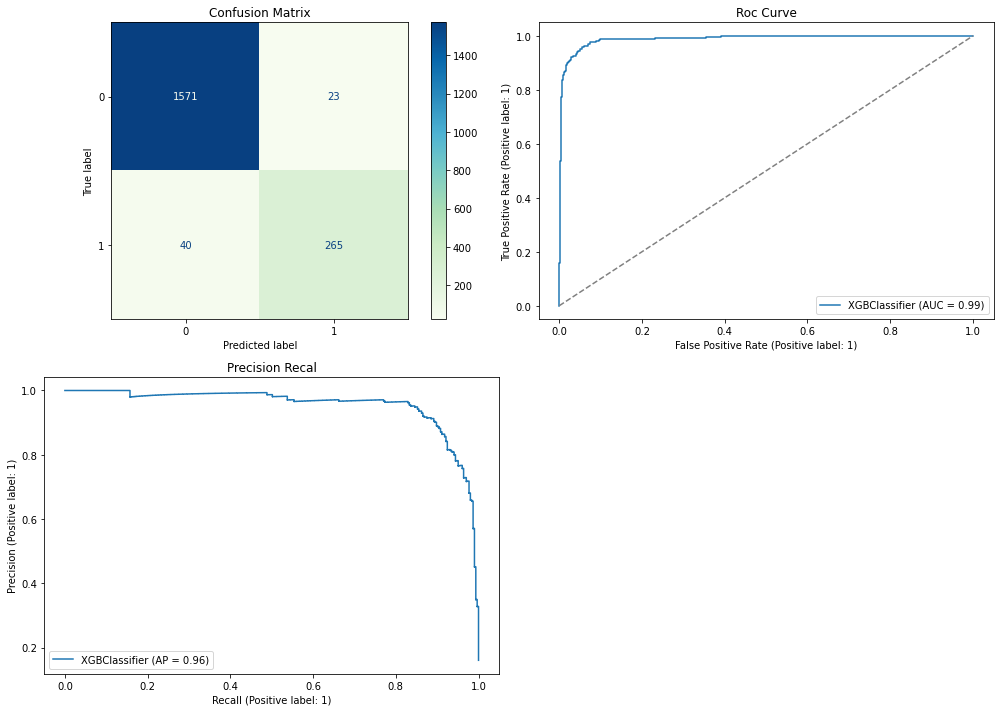

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1594
           1       0.92      0.87      0.89       305

    accuracy                           0.97      1899
   macro avg       0.95      0.93      0.94      1899
weighted avg       0.97      0.97      0.97      1899

Accuracy: 0.967
Precision: 0.92
Recall: 0.869
F1-score: 0.894
ROC-AUC score: 0.989


In [42]:
# Функция применения модели, подбор некоторых параметров и отображения оценки качества модели.
# По задаче метрика f1.
model_ml = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic'), param_grid=param, cv=5, n_jobs=-1, verbose=1, 
                        scoring='f1')
model_ml.fit(X_train, y_train)
best_estimator = model_ml.best_estimator_
print('Best estimator:', best_estimator)
best_score = model_ml.best_score_
print('Best score:', best_score)
best_params = model_ml.best_params_
print('Params:', best_params)
y_pred = model_ml.predict(X_test)
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, y_test, ax=ax1, cmap='GnBu')
ax1.grid(False)
ax1.set_title('Confusion Matrix')

RocCurveDisplay.from_estimator(best_estimator, X_test, y_test, ax=ax2)
ax2.set_title('Roc Curve')
ax2.plot([0, 1], [0, 1], color="gray", linestyle="--")

PrecisionRecallDisplay.from_estimator(best_estimator, X_test, y_test, ax=ax3)
ax3.set_title('Precision Recal')

plt.tight_layout()   
plt.show()

print('Classification Report:')
print(classification_report(y_test, y_pred))

accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
roc_auc = round(roc_auc_score(y_test, model_ml.predict_proba(X_test)[:, 1]), 3)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('ROC-AUC score:', roc_auc)

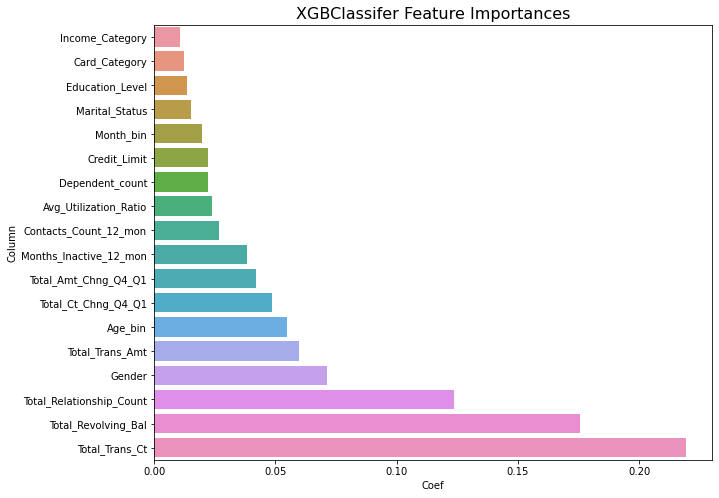

In [43]:
# Feature Importances для XGBClassifer.
coefs = pd.DataFrame({'Column': X.columns, 'Coef': best_estimator.feature_importances_})
sort_coefs = coefs.sort_values(by='Coef')
plt.figure(figsize=(10, 8))
sns.barplot(data=sort_coefs, y='Column', x='Coef', orient='h')
plt.title('XGBClassifer Feature Importances', fontsize=16)
plt.show()

In [44]:
# Тестовую выборку стандартизируем.
test_valid = scaler.transform(test_valid)

In [45]:
# Предсказание для тестовой выборки.
y_check = model_ml.predict(test_valid)

In [46]:
# Отображение предсказания для тестовой выборки.
y_check

array([0, 0, 0, ..., 0, 1, 0])

In [47]:
# Формируем фрейм из номера строки и churn, сохраняем в csv.
validation_test = pd.concat([pd.Series(client_id, name='client_id'), pd.Series(y_check, name='churn')], 
                            axis=1)
validation_test.to_csv('7_result_leontevaog.csv', index=False)